# Error Map & Analysis

## 0. Setting

In [2]:
import cv2
import matplotlib.pyplot as plt
import core.models.raft.raft as flow_model
import core.models.raft.flow_viz as flow_viz
import torch
import numpy as np
import torchvision.transforms.functional as F
import torchvision.transforms as transforms

In [42]:
market0 = cv2.cvtColor(cv2.imread('demo/images/market0.png'),cv2.COLOR_BGR2RGB)
market1 = cv2.cvtColor(cv2.imread('demo/images/market1.png'),cv2.COLOR_BGR2RGB)
market_pred = cv2.cvtColor(cv2.imread('demo/base_output/market/5-interp-img.png'),cv2.COLOR_BGR2RGB)
market_gt = cv2.cvtColor(cv2.imread('demo/images/marketgt.png'),cv2.COLOR_BGR2RGB)

ambush50 = cv2.cvtColor(cv2.imread('demo/images/ambush50.png'),cv2.COLOR_BGR2RGB)
ambush51 = cv2.cvtColor(cv2.imread('demo/images/ambush51.png'),cv2.COLOR_BGR2RGB)
ambush5_pred = cv2.cvtColor(cv2.imread('demo/base_output/ambush5/5-interp-img.png'),cv2.COLOR_BGR2RGB)
ambush5_gt = cv2.cvtColor(cv2.imread('demo/images/ambush5gt.png'),cv2.COLOR_BGR2RGB)

glider0 = cv2.cvtColor(cv2.imread('demo/images/glider0.png'),cv2.COLOR_BGR2RGB)
glider1 = cv2.cvtColor(cv2.imread('demo/images/glider1.png'),cv2.COLOR_BGR2RGB)
glider_pred = cv2.cvtColor(cv2.imread('demo/base_output/glider/5-interp-img.png'),cv2.COLOR_BGR2RGB)
glider_gt = cv2.cvtColor(cv2.imread('demo/images/glidergt.png'),cv2.COLOR_BGR2RGB)

print(glider_gt.shape, glider_gt.dtype)

(540, 960, 3) uint8


## 1. Error Map

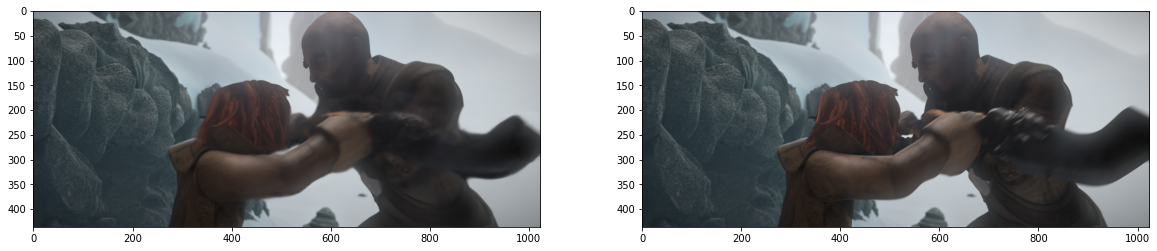

0.24669704685438779

In [71]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(ambush5_pred)
ax[1].imshow(ambush5_gt)
plt.show()
np.abs(ambush5_gt - ambush5_pred).mean() / 255

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


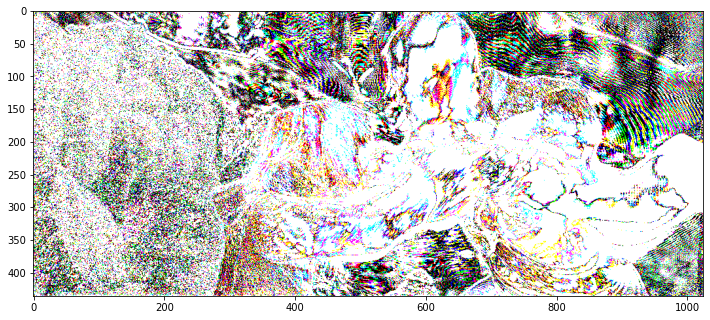

182.0

In [51]:
plt.figure(figsize=(12,8))
plt.imshow(np.abs(ambush5_gt.astype('float32') - ambush5_pred.astype('float32')).clip(0,255))
plt.show()
np.abs(ambush5_gt.astype('float32') - ambush5_pred.astype('float32')).max()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


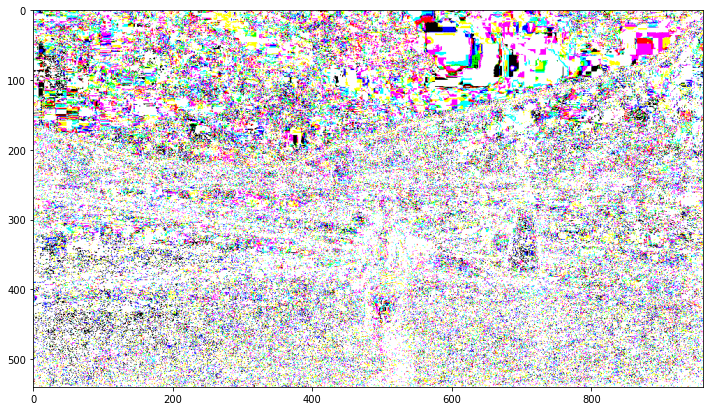

133.0

In [59]:
plt.figure(figsize=(12, 8))
plt.imshow(np.abs(glider_gt.astype('float32') - glider_pred.astype('float32')).clip(0,255))
plt.show()
np.abs(glider_gt.astype('float32') - glider_pred.astype('float32')).max()

## 2. Feature Matching

In [ ]:
def flow_vis(bi_flow):
    flow01 = bi_flow[:, :, :2]
    flow10 = bi_flow[:, :, 2:]
    flow01 = flow_viz.flow_to_image(flow01, convert_to_bgr=True)
    flow10 = flow_viz.flow_to_image(flow10, convert_to_bgr=True)
    bi_flow = np.concatenate([flow01, flow10], axis=1)
    return bi_flow

def raft_transform(img):
    img = torch.tensor(img)
    img = img.permute(2,0,1).unsqueeze(0)
    crop_size = [512,896]   # [520, 960]
    img = F.resize(img, size=crop_size, antialias=False).type(torch.float32)
    print(img.shape, img.dtype)
    return img

# Img Show
def img_show(img, size=(10,6)):
  plt.figure(figsize=size)
  plt.imshow(img)
  plt.axis('off')
  plt.show()

# dual img show
def dual_img_show(img0, img1, size=(14,6)):
  plt.figure(figsize=size)
  plt.subplot(1, 2, 1)
  plt.axis('off')
  plt.imshow(img0)

  plt.subplot(1,2,2)
  plt.imshow(img1)
  plt.axis('off')
  plt.show()

# Feature Extraction ####################################################
# OpenCV SIFT Algorithm
def opencv_sift(img, nf=None, no=4, ct=0.04, et=10, s=1.6, draw_rich=False):
    radian = 4
    color = (255,0,0)
    thickness = 1

    # GrayScale Transformation.
    gray= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # SIFT Feature Extractor.
    SIFT = cv2.SIFT_create(nfeatures=nf, nOctaveLayers=no, contrastThreshold=ct, edgeThreshold=et, sigma=s)
    
    # Keypoint 검출 및 Descriptor 계산.
    keypoints, descriptors = SIFT.detectAndCompute(gray, None)
    print(f"keypoints: {len(keypoints)} {keypoints[0]}")
    print(f"descriptors: {len(descriptors)}, {descriptors.shape}")
    print(descriptors[0,:10])
    
    # 키 포인트 그리기.
    # img=cv2.drawKeypoints(img, keypoints, outImage=None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    # print(f'SIFT img: {img.shape}, {img.dtype}, {img.mean()}')

    if draw_rich:
        cv2.drawKeypoints(img, keypoints, outImage=None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    else:
        kp_xy = cv2.KeyPoint_convert(keypoints)
        for x,y in kp_xy:
            cv2.circle(img, (int(x),int(y)), radian, color, thickness)

    # fig_file = fig_path + 'OpenCV_SIFT.png'
    # cv2.imwrite(fig_file, img)
    return img, keypoints, descriptors

  # Feature Matching ####################################################
# create feature matcher
def BFMatching(fea0, fea1):
    img0, key0, dsp0 = fea0
    img1, key1, dsp1 = fea1

    bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
    # match descriptors of both images
    matches = bf.match(dsp0, dsp1)
    
    # sort matches by distance
    matches = sorted(matches, key = lambda x:x.distance)
    
    # draw first 20 matches
    matched_img = cv2.drawMatches(img0, key0, img1, key1, matches[:20], img1, flags=2)

    # store good matches as per ratio 0.7
    threshold = int(len(matches) * 0.7)
    # threshold = 30
    good = matches[:threshold]
 
    print(f'BFM matched img: {matched_img.shape}, {matched_img.dtype}')
    print(f'BFM matched pairs: {len(matches)}, {matches[:4]}')
    print(f'Good Matched pairs: {len(good)}, {matches[:4]}')
    
    # fig_file = fig_path + 'OpenCV_Feature_matching.png'
    # cv2.imwrite(fig_file, matched_img)
    return matched_img, good, key0, key1, dsp0, dsp1

### Histogram Equalization

In [11]:
def equalize_brightness(image):
    # 히스토그램 균일화를 위해 BGR 이미지를 YUV 색공간으로 변환
    yuv_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)

    # Y 채널만 가져오기
    y_channel = yuv_image[:,:,0]

    # Y 채널에 히스토그램 균일화 적용
    equalized_y_channel = cv2.equalizeHist(y_channel)

    # 균일화된 Y 채널을 원본 이미지에 다시 적용
    yuv_image[:,:,0] = equalized_y_channel

    # YUV 색공간을 다시 BGR로 변환
    equalized_image = cv2.cvtColor(yuv_image, cv2.COLOR_YUV2BGR)

    return equalized_image

In [12]:
equal_img0 = equalize_brightness(market0)
equal_img1 = equalize_brightness(market1)

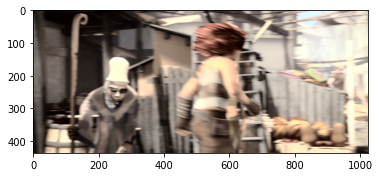

In [17]:
plt.imshow(equal_img0)
plt.show()

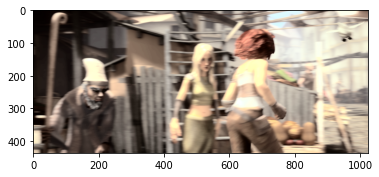

In [18]:
plt.imshow(equal_img1)
plt.show()

## Feature Matching guide

In [19]:
fea0 = opencv_sift(market0, nf=None, no=4, ct=0.08, et=7, s=1.6)
pal0, kp0, des0 = fea0
print()
fea1 = opencv_sift(market1, nf=None, no=4, ct=0.08, et=7, s=1.6)
pal1, kp1, des1 = fea1

keypoints: 59 < cv2.KeyPoint 0x7fd8d0174b10>
descriptors: 59, (59, 128)
[ 23.  35.  18.   1.   4.   2.   1.   2. 135.  16.]

keypoints: 140 < cv2.KeyPoint 0x7fd8c87c1450>
descriptors: 140, (140, 128)
[0. 0. 0. 0. 0. 0. 0. 0. 3. 0.]


In [20]:
BFM_matched_img, BFM_matched_pairs, matched_key0, matched_key1, matched_dsp0, matched_dsp1 = BFMatching(fea0, fea1)

BFM matched img: (436, 2048, 3), uint8
BFM matched pairs: 42, [< cv2.DMatch 0x7fd8d00729f0>, < cv2.DMatch 0x7fd8d00729d0>, < cv2.DMatch 0x7fd8d0072630>, < cv2.DMatch 0x7fd8d0072990>]
Good Matched pairs: 29, [< cv2.DMatch 0x7fd8d00729f0>, < cv2.DMatch 0x7fd8d00729d0>, < cv2.DMatch 0x7fd8d0072630>, < cv2.DMatch 0x7fd8d0072990>]


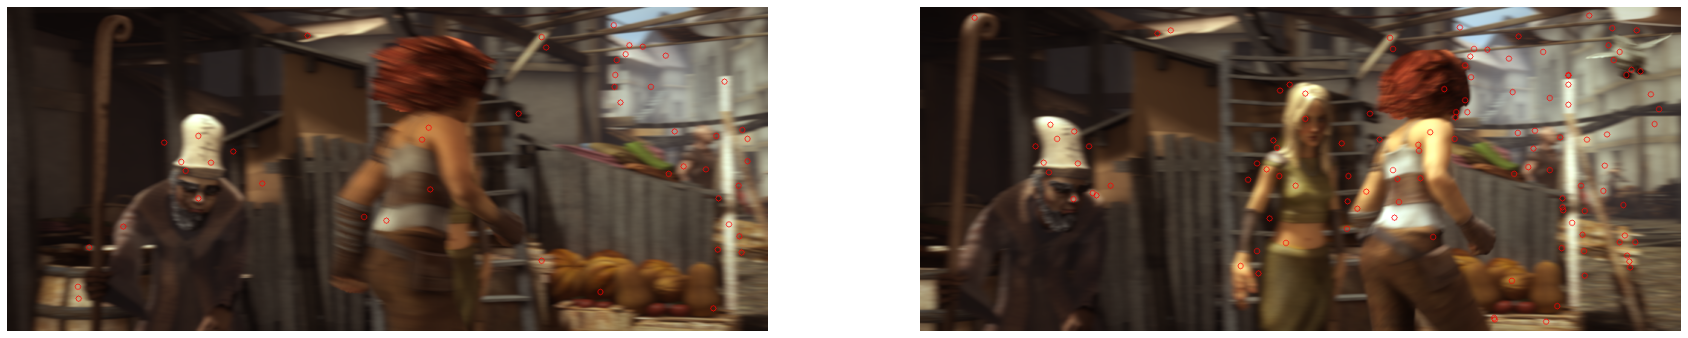

In [21]:
dual_img_show(pal0, pal1, (30,15))

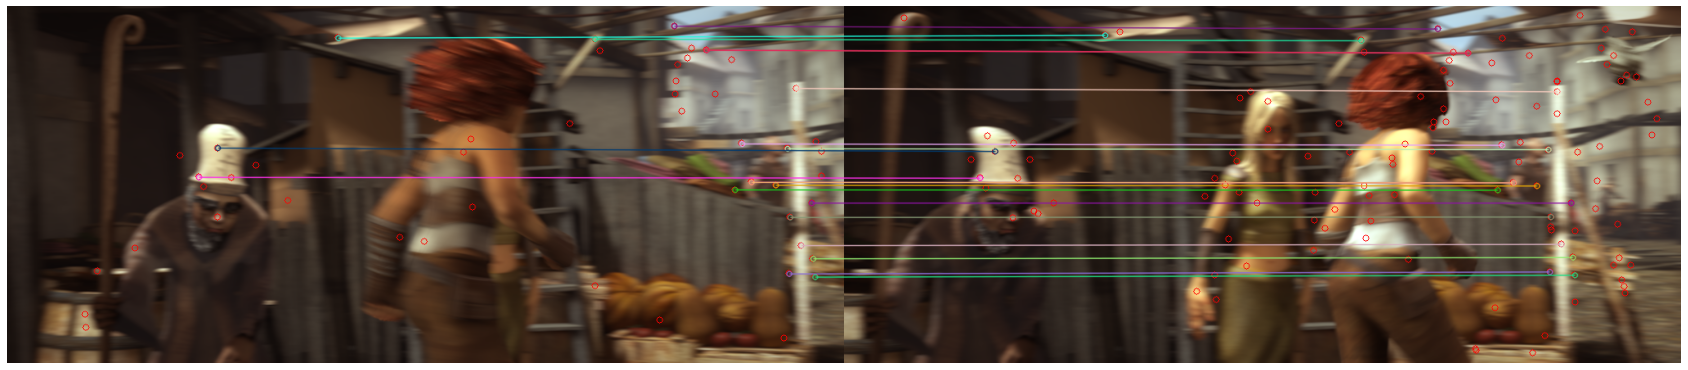

In [22]:
img_show(BFM_matched_img, size=(30,15))

In [52]:
transform = transforms.ToTensor()
fea0_tensor = transform(pal0)
print(fea0_tensor.shape)

torch.Size([3, 436, 1024])


In [53]:
print(BFM_matched_pairs[0].queryIdx)
print(BFM_matched_pairs[0].trainIdx)
print(BFM_matched_pairs[0].distance)

43
85
239.0


In [54]:
np.linalg.norm(np.array(matched_dsp0[BFM_matched_pairs[0].queryIdx]) - np.array(matched_dsp1[BFM_matched_pairs[0].trainIdx]), ord=2)

35.454197

In [56]:
np.array(matched_key0[BFM_matched_pairs[0].queryIdx].pt)

array([898.99603271, 167.98043823])

In [57]:
np.array(matched_key1[BFM_matched_pairs[0].trainIdx].pt)

array([804.84442139, 169.63517761])

In [58]:
key0 = cv2.KeyPoint_convert(matched_key0)
key1 = cv2.KeyPoint_convert(matched_key1)